In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps
import pandas as pd

from utils.preprocessing import *
from utils.util import chainer


import core.config as conf

## Load data

In [2]:
data_path = conf.raw_lzo_path + 'part-00000'
ori_df = read_data(data_path)
df = ori_df[['hashtags', 'tweet_type', 'language', 'tweet_id', 'reply_timestamp', 'retweet_timestamp', 'comment_timestamp', 'like_timestamp']].copy()
df = df.dropna(subset=['hashtags'])

print('total exampls with hastags: ', len(df['hashtags'].dropna()))

total exampls with hastags:  597028


In [3]:
df.head()

,hashtags,tweet_type,language,tweet_id,reply_timestamp,retweet_timestamp,comment_timestamp,like_timestamp
24,D79DBEE00CCE361AE78BBBB98713C300,TopLevel,E7F038DE3EAD397AEC9193686C911677,DC1211D7C6FB5F8872604D4B7B75FAA4,NaN,NaN,NaN,1.612785e+09
31,4F3903BE060AB0BA12071617E7B00123\t4E3B51DC2EA6...,Quote,E7F038DE3EAD397AEC9193686C911677,358BE3110E688E1FE49409BC48C7251F,NaN,NaN,NaN,1.613362e+09
37,B8E47183FFBA0200590572D127D16E75,TopLevel,1F73BB863A39DB62B4A55B7E558DB1E8,C9AC24689F480617FF5C630FCE677FEB,NaN,NaN,NaN,NaN
40,B96A690CE6C1D3EA55EB455D9C0FD6B0,Retweet,B8B04128918BBF54E2E178BFF1ABA833,29D36080D3982AA2DB5E36A3E1828FD4,NaN,NaN,NaN,1.613363e+09
45,F8F9B27F501A556D4E67CF0C983928CD,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,C4C525A8D504354BC8C4DBE974BF812E,NaN,NaN,NaN,NaN


In [4]:
df['hashtags_list'] = df['hashtags'].str.split('\t')
df['hashtags_cnt'] = df['hashtags'].str.count('\t')
df['hashtags_cnt'] = df['hashtags_cnt'].astype(int) + 1

print('max hashtag count: ', df['hashtags_cnt'].max())
print('min hashtag count: ', df['hashtags_cnt'].min())

max hashtag count:  43
min hashtag count:  1


In [5]:
df = pd.DataFrame({
    'id': np.repeat(df.index.to_series(), df['hashtags_cnt']),
    'tweet_type': np.repeat(df['tweet_type'], df['hashtags_cnt']),
    'language': np.repeat(df['language'], df['hashtags_cnt']),
    'retweet_timestamp': np.repeat(df['retweet_timestamp'], df['hashtags_cnt']),
    'comment_timestamp': np.repeat(df['comment_timestamp'], df['hashtags_cnt']),
    'like_timestamp': np.repeat(df['like_timestamp'], df['hashtags_cnt']),
    'reply_timestamp': np.repeat(df['reply_timestamp'], df['hashtags_cnt']),
    'hashtags': chainer(df['hashtags']) # row로 나누기
})


In [6]:
df.head()

,id,tweet_type,language,retweet_timestamp,comment_timestamp,like_timestamp,reply_timestamp,hashtags
24,24,TopLevel,E7F038DE3EAD397AEC9193686C911677,NaN,NaN,1.612785e+09,NaN,D79DBEE00CCE361AE78BBBB98713C300
31,31,Quote,E7F038DE3EAD397AEC9193686C911677,NaN,NaN,1.613362e+09,NaN,4F3903BE060AB0BA12071617E7B00123
31,31,Quote,E7F038DE3EAD397AEC9193686C911677,NaN,NaN,1.613362e+09,NaN,4E3B51DC2EA6A32D978F36161332EC58
31,31,Quote,E7F038DE3EAD397AEC9193686C911677,NaN,NaN,1.613362e+09,NaN,F04AF392980A866C6E9CDD88140CA8C8
31,31,Quote,E7F038DE3EAD397AEC9193686C911677,NaN,NaN,1.613362e+09,NaN,A5983BDB54034E19B1124E50B4CD3979


In [7]:
len(df)

1201106

## Encode hashtags & langauge

In [8]:
# language encode

langauge_df = read_data('../data/language.csv', sep=',', features=['language_id', 'language', 'language_type']).reset_index(drop=True)

language_to_idx = dict(zip(langauge_df['language'], langauge_df['language_id']))
idx_to_language = dict(zip(langauge_df['language_id'], langauge_df['language']))

df['language_encode'] = df['language'].apply(lambda x: language_to_idx[x])

In [9]:
# labeling
for label in (conf.labels):
    label_name = label.split('_')[0]
    df.loc[df[label]<=0, label_name ] = 0
    df.loc[df[label]>0, label_name ] = 1
    df = df.drop([label], axis=1)

In [10]:
# hashtag encode
var = df['hashtags'].fillna('').values.copy()
gc.collect()

PD = {}
null = var[0]
PD[null] = [0,0]
count = 1
for v in var:
    if v not in PD:
        PD[v] = [count,1]
        count +=1
    else:
        x = PD[v]
        x[1] += 1
        PD[v] = x

vari = []
for v in var:
    li=[]
    lf=[]
    if v!='':
        li.append(PD[v][0])
        lf.append(-PD[v][1])
    vari.append( list(np.array(li)[np.argsort(lf)].astype(np.int32) ) )
    
del PD
gc.collect()

len(vari), vari[:10]

(1201106, [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]])

In [11]:
df['hashtags_encode'] = np.array( [v[0] for v in vari ] ).astype( np.int32 )

In [12]:
df

,id,tweet_type,language,hashtags,language_encode,reply,retweet,comment,like,hashtags_encode
24,24,TopLevel,E7F038DE3EAD397AEC9193686C911677,D79DBEE00CCE361AE78BBBB98713C300,1,NaN,NaN,NaN,1.0,0
31,31,Quote,E7F038DE3EAD397AEC9193686C911677,4F3903BE060AB0BA12071617E7B00123,1,NaN,NaN,NaN,1.0,1
31,31,Quote,E7F038DE3EAD397AEC9193686C911677,4E3B51DC2EA6A32D978F36161332EC58,1,NaN,NaN,NaN,1.0,2
31,31,Quote,E7F038DE3EAD397AEC9193686C911677,F04AF392980A866C6E9CDD88140CA8C8,1,NaN,NaN,NaN,1.0,3
31,31,Quote,E7F038DE3EAD397AEC9193686C911677,A5983BDB54034E19B1124E50B4CD3979,1,NaN,NaN,NaN,1.0,4
...,...,...,...,...,...,...,...,...,...,...
3033882,3033882,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,98ED938DD3CEFD0E6D81FA6CAC87BE2F,3,NaN,NaN,NaN,NaN,67083
3033890,3033890,TopLevel,E7F038DE3EAD397AEC9193686C911677,B0B8E5E48AE310E2CA68676E875508FC,1,NaN,NaN,NaN,NaN,179691
3033890,3033890,TopLevel,E7F038DE3EAD397AEC9193686C911677,40FA09B1708D0DF3F80B108E583E9052,1,NaN,NaN,NaN,NaN,24803
3033890,3033890,TopLevel,E7F038DE3EAD397AEC9193686C911677,2AEF894F73223507D1DB77032314BAED,1,NaN,NaN,NaN,NaN,179692


In [13]:
print('total rows: ', len(df))
print('total unique hashtags: ', len(df['hashtags'].unique()))

total rows:  1201106
total unique hashtags:  324775


In [14]:
language_cnt = df['language_encode'].value_counts().sort_values()[::-1]

In [15]:
language_cnt

0     379108
1     309342
8      96006
2      69345
4      68877
       ...  
52        32
59         8
62         5
61         3
63         1
Name: language_encode, Length: 63, dtype: int64

In [16]:
hashtag_cnt = df['hashtags_encode'].value_counts().sort_values()[::-1]

In [17]:
hashtag_cnt

206       12825
195        4992
7          4000
51         3775
398        3082
          ...  
96973         1
84683         1
82634         1
265827        1
189665        1
Name: hashtags_encode, Length: 324775, dtype: int64

In [22]:
language_types = langauge_df.language_id.to_list()
n_languages = len(language_types)

In [23]:
# Declaring some auxiliary structures
n_engagements_arr = np.zeros(n_languages).astype('int32')
n_positive_engagements_arr = np.empty(n_languages).astype('int32')
n_negative_engagements_arr = np.empty(n_languages).astype('int32')
n_like_engagements_arr = np.empty(n_languages).astype('int32')
n_retweet_engagements_arr = np.empty(n_languages).astype('int32')
n_reply_engagements_arr = np.empty(n_languages) .astype('int32')
n_comment_engagements_arr = np.empty(n_languages).astype('int32')

In [25]:
aggregate_result = df.groupby(['language_encode', 'hashtags_encode']).sum()
aggregate_result.head()

id  reply  retweet  comment  like
language_encode hashtags_encode                                         
0               0                 6683139    0.0      0.0      0.0   2.0
                2                 6164547    0.0      0.0      0.0   1.0
                7                31696577    0.0      3.0      1.0  12.0
                8                 6910471    0.0      0.0      0.0   1.0
                9                48419395    0.0      8.0      0.0  14.0

In [26]:
aggregate_result = df.groupby(['language_encode', 'hashtags_encode']).count()
aggregate_result = aggregate_result[["hashtags"]]
aggregate_result['cnt'] = aggregate_result['hashtags']
aggregate_result = aggregate_result.drop('hashtags', axis=1)

In [27]:
aggregate_result = aggregate_result.reset_index()

In [28]:
aggregate_result.head()

,language_encode,hashtags_encode,cnt
0,0,0,3
1,0,2,4
2,0,7,25
3,0,8,3
4,0,9,29


In [29]:
len(aggregate_result)

386859

In [38]:
top_n = 100
language_hashtags = [[] for _ in range(n_languages)]
for i in range(n_languages):
    try:
        tmp = aggregate_result.loc[aggregate_result['language_encode'] == i]
        tmp = tmp.sort_values('cnt', ascending=False)[:top_n]
        

        # tmp = sorted(aggregate_result.loc[aggregate_result['language_encode'] == 0]['cnt'], reverse=True)[:30]
        # tmp = tmp[['cnt']].sort_values("cnt", ascending=False)

        language_hashtags[i] = tmp
    except:
        pass

In [40]:
language_hashtags[0]['cnt']

112     2586
29      2045
227     1734
312     1527
146     1242
        ... 
825      222
1156     221
2115     220
723      218
1711     218
Name: cnt, Length: 100, dtype: int64

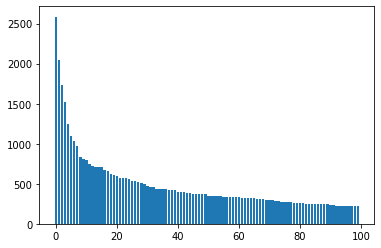

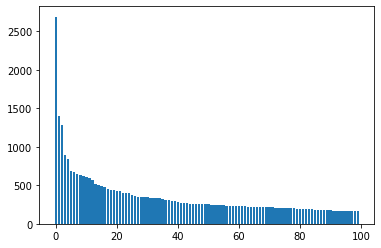

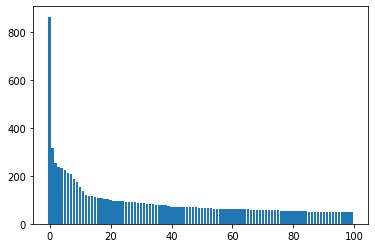

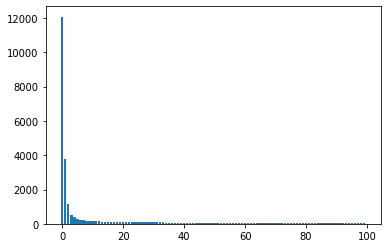

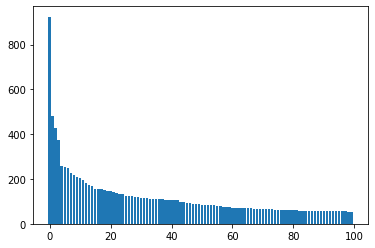

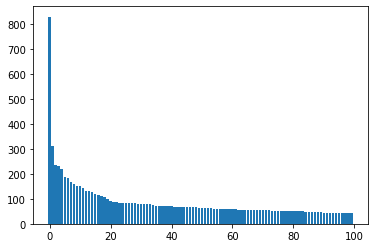

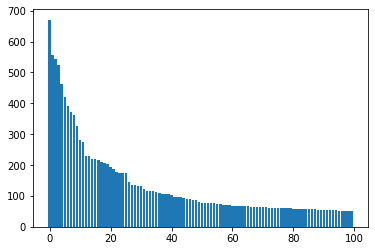

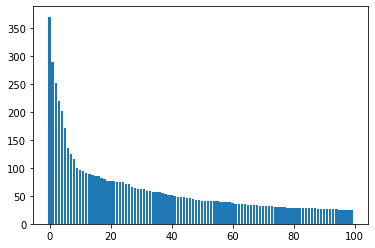

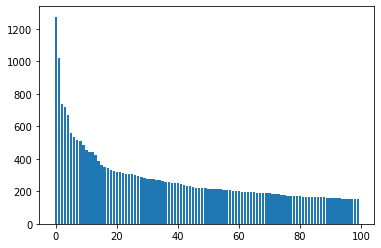

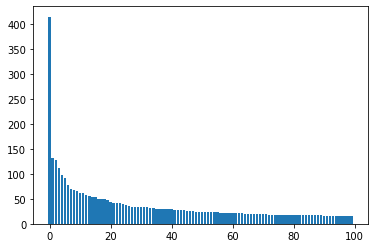

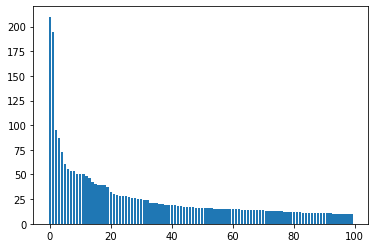

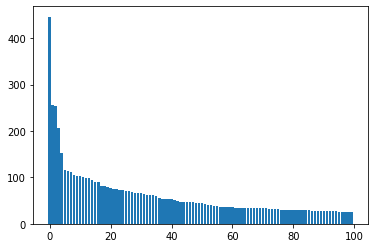

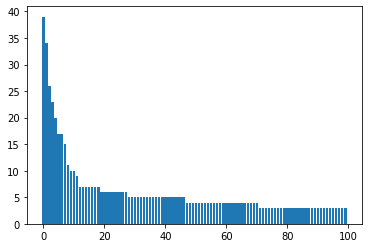

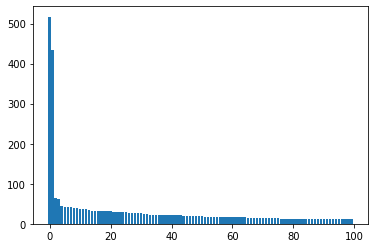

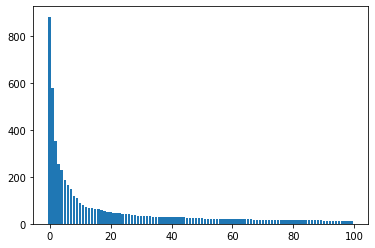

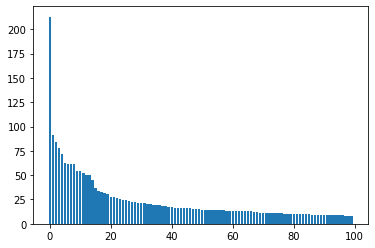

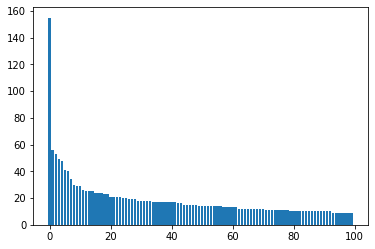

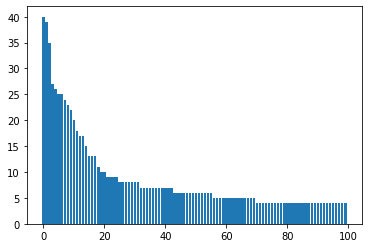

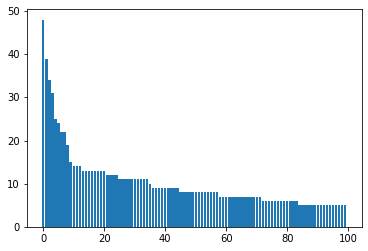

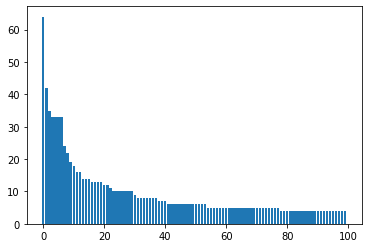

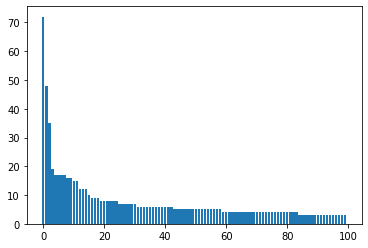

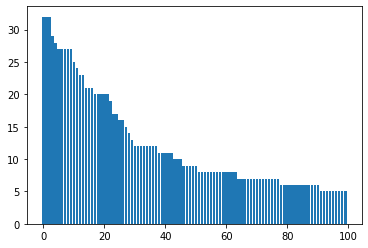

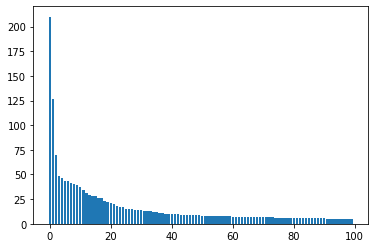

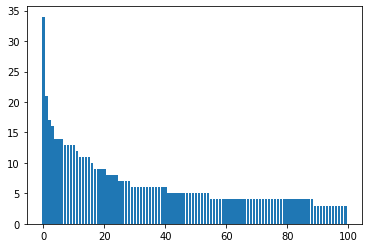

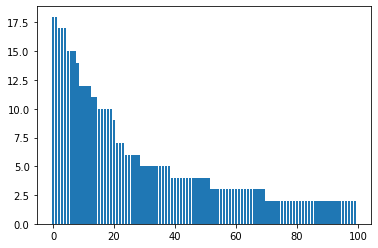

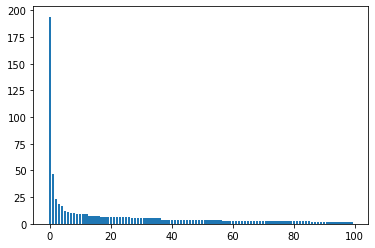

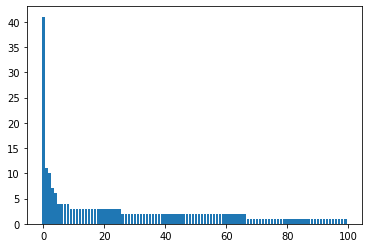

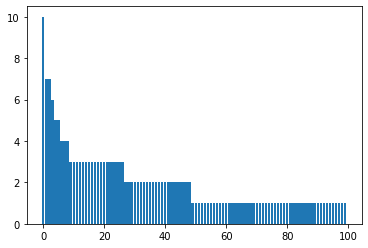

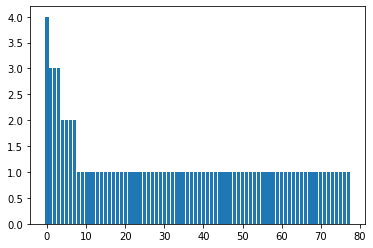

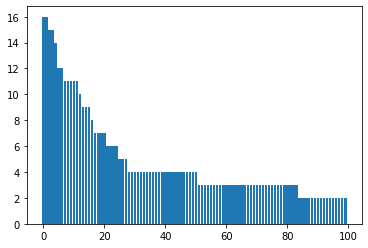

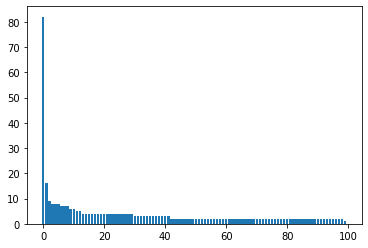

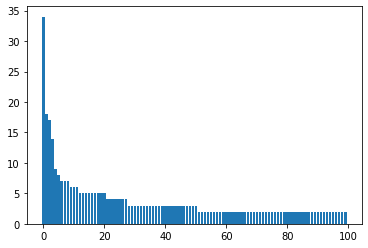

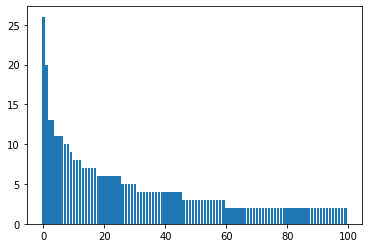

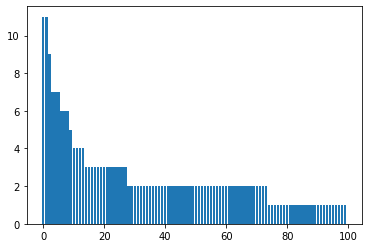

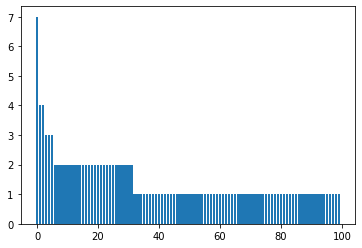

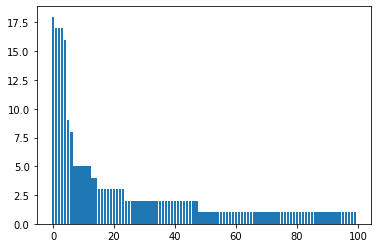

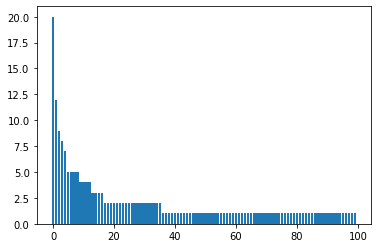

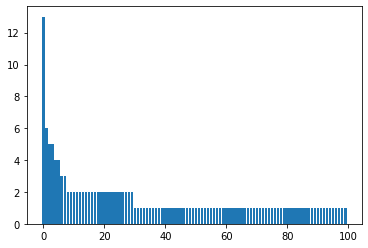

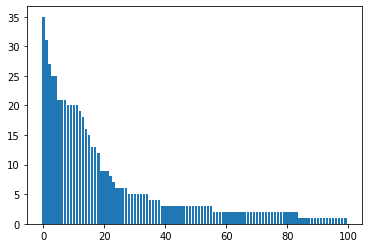

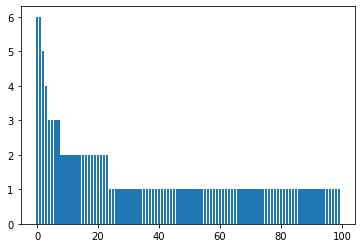

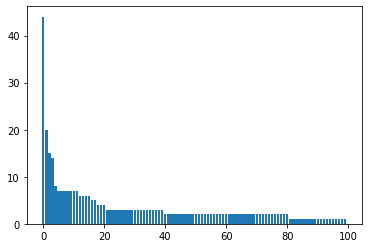

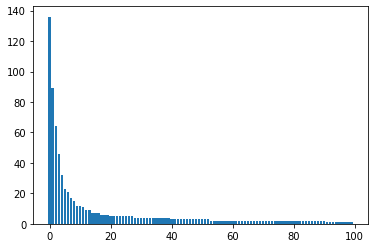

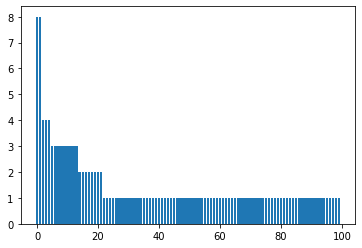

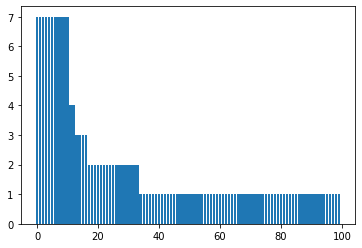

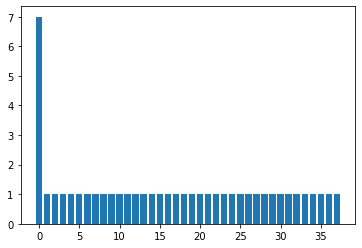

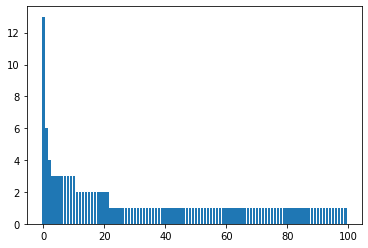

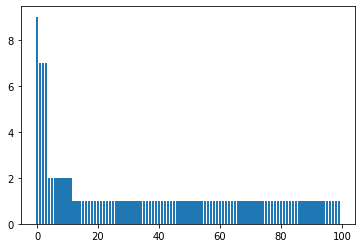

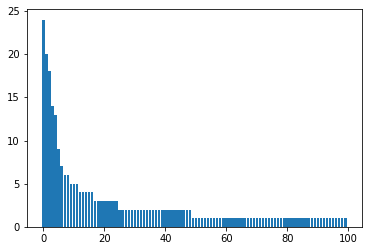

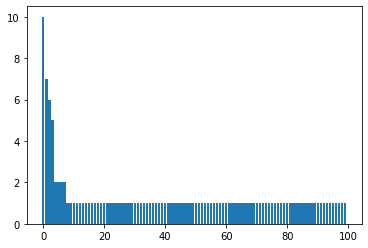

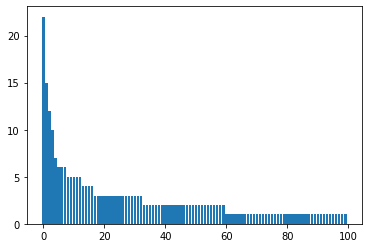

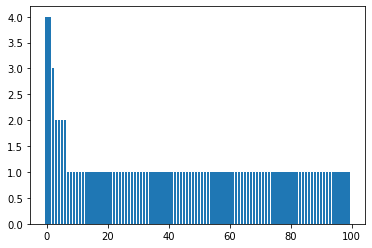

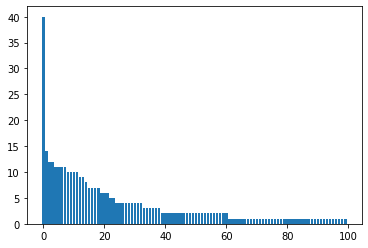

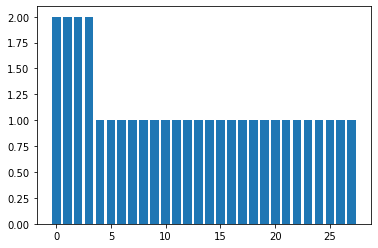

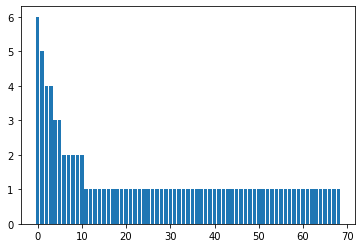

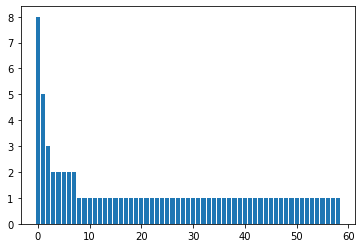

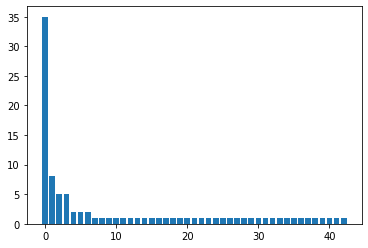

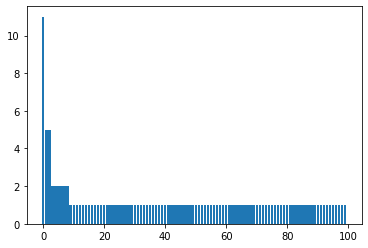

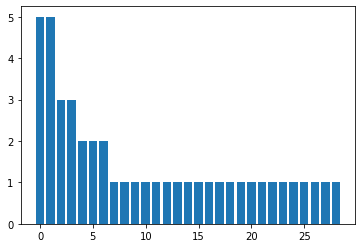

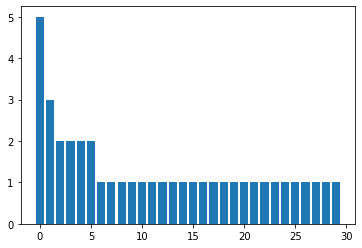

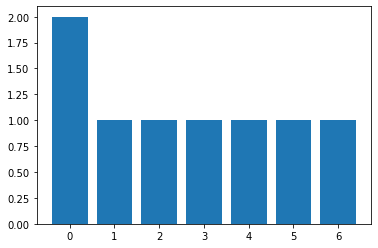

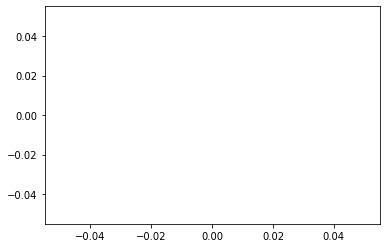

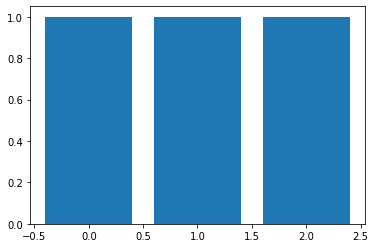

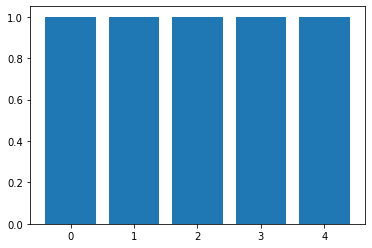

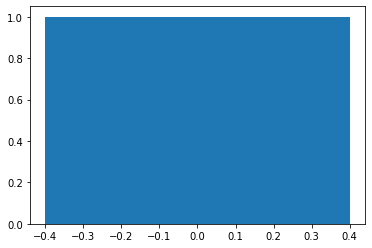

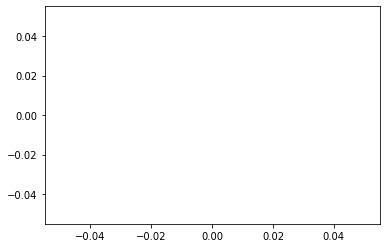

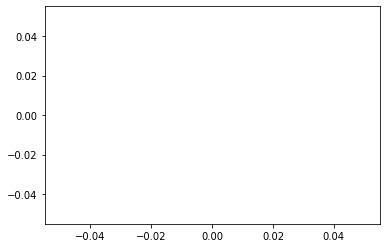

In [41]:
for i in range(n_languages):
    plt.bar(range(len(language_hashtags[i])), language_hashtags[i]['cnt'])
    plt.show()

In [43]:
for i in range(n_languages):
    if len(language_hashtags[i]['cnt']) == 0:
        print(f"Language {i} - max tag count: 0 ")
    else:
        max_cnt = language_hashtags[i]['cnt'].max()
        print(f"Language {i} - max tag count: {int(max_cnt):n} ")

Language 0 - max tag count: 2586 
Language 1 - max tag count: 2689 
Language 2 - max tag count: 865 
Language 3 - max tag count: 12077 
Language 4 - max tag count: 924 
Language 5 - max tag count: 830 
Language 6 - max tag count: 671 
Language 7 - max tag count: 370 
Language 8 - max tag count: 1275 
Language 9 - max tag count: 414 
Language 10 - max tag count: 210 
Language 11 - max tag count: 446 
Language 12 - max tag count: 39 
Language 13 - max tag count: 517 
Language 14 - max tag count: 883 
Language 15 - max tag count: 213 
Language 16 - max tag count: 155 
Language 17 - max tag count: 40 
Language 18 - max tag count: 48 
Language 19 - max tag count: 64 
Language 20 - max tag count: 72 
Language 21 - max tag count: 32 
Language 22 - max tag count: 210 
Language 23 - max tag count: 34 
Language 24 - max tag count: 18 
Language 25 - max tag count: 194 
Language 26 - max tag count: 41 
Language 27 - max tag count: 10 
Language 28 - max tag count: 4 
Language 29 - max tag count: 16